# Geodatenanalyse 2: Termin 8 - Zeitreihenvorhersage und rekurrente neuronale Netze

## Zeitreihenvorhersage mit 1D-CNN

Ziel der Übung: Grundwasserstand simulieren für einen Zeitraum von 4 Jahren basierend auf meteorologischen Inputdaten (z.B. Niederschlag). 

Wir können KNN verwenden um den Zusammenhang zwischen relevanten meteorologischen Parametern wie Niederschlag oder Temperatur und dem Grundwasserstand herzustellen, auch ohne die direketen Prozesse (Grundwasserneubildung, Evapotranspiration, ...) zu definieren. 



### set random seed
Um ein reproduzierbares Ergebnis zu erhalten definieren wir zunächst die Startpunkte (seeds) der Zufallszahlengeneratoren von numpy und tensorflow:

In [1]:
#set random seed for reproducability
from numpy.random import seed
seed(347824) # this is a randomly chosen number

from tensorflow import random
random.set_seed(63494) # this is also a randomly chosen number

print("seeds are set")

seeds are set


### load data
Die (wöchentlich) Grundwasserdaten befinden sich in der Datei: **GW-Data.csv**  
Die meteorologischen Inputdaten in der Datei: **Climate-Data.csv**

Wir laden die Dateien als pandas Dataframe mit einem datetimeindex ein und führen beide Dateien zusammen. Ein weiteres Preprocessing ist in diesem Fall nicht nötig, da die Daten schon auf Datenlücken/Fehlwerte etc. untersucht und bereinigt wurden. Auch decken alle Daten den gleichen Zeitraum ab und verfügen über ein identisches Sampling Intervall (1 Woche).

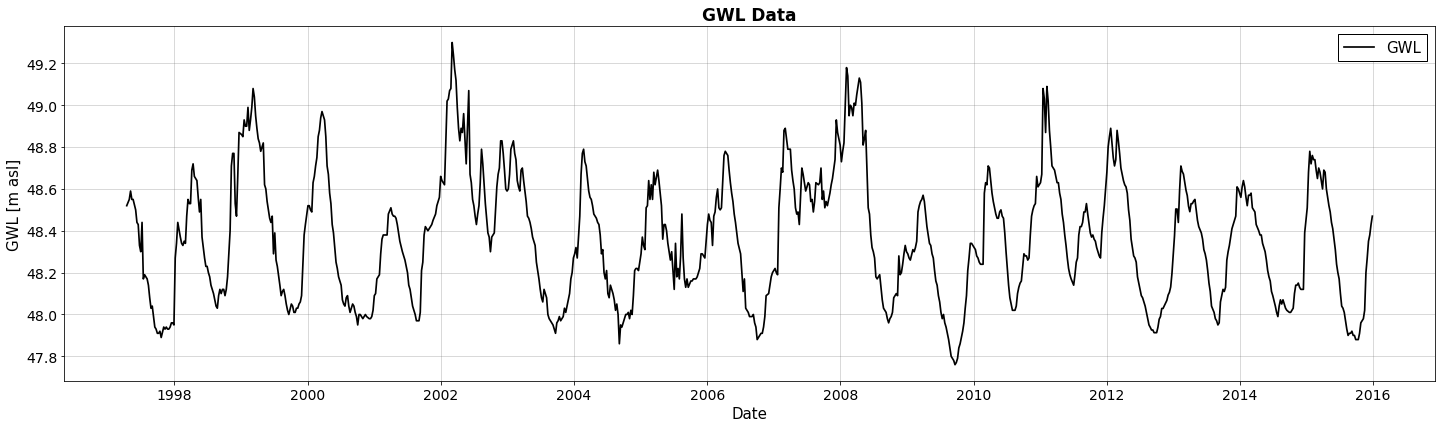

,GWL,P,rH,T,Tsin
Date,,,,,
1997-04-14,48.520,1.203046,62.731979,6.593939,-1.439494
1997-04-21,48.535,0.864522,61.926402,4.493416,-0.347873
1997-04-28,48.550,7.486455,62.071464,9.000969,0.748794
1997-05-05,48.590,30.453424,80.260318,11.661238,1.834601
1997-05-12,48.550,15.360879,71.335400,10.898702,2.893801


In [2]:
import pandas as pd
import numpy as np

GWData = pd.read_csv('./GW-Data.csv',
                     parse_dates=['Date'], # hiermit werden Zeitangaben als Datum erkannt
                     index_col=0, # definiert welche Spalte der gelesenen Daten als Index für den DataFrame dienen soll
                     dayfirst = True, # definiert das Datumsformat 
                     decimal = '.', sep=',') # Angaben welche Trennzeichen in der Datei verwendet werden

ClimateData = pd.read_csv('Climate-Data.csv', 
                          parse_dates=['Date'],index_col=0,dayfirst = True,
                          decimal = '.', sep=',')

# Beide DataFrames zusammenführen
data = pd.merge(GWData, ClimateData, how='inner', left_index = True, right_index = True) # beide DataFrames zusammenführen



import matplotlib.pyplot as plt

#plot GWL data
plt.figure(figsize=(20,6))
plt.plot(data.index,data['GWL'], 'k', label ="GWL", linewidth = 1.7)
plt.title("GWL Data", size=17,fontweight = 'bold')
plt.ylabel('GWL [m asl]', size=15)
plt.xlabel('Date',size=15)
plt.legend(fontsize=15,loc='upper right',fancybox = False, framealpha = 1, edgecolor = 'k')
plt.tight_layout()
plt.grid(b=True, which='major', color='#666666', alpha = 0.3, linestyle='-')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

#inspect the data
data.head()

Der DataFrame setzt sich nun zusammen aus der Indexspalte **Date**, dem Grundwasserstand **GWL**, Niederschlag **P**, relativer Feuchte **rH**, Temperatur **T** und einem geglätteten Temperatursignal **Tsin** (Sinuskurve an T gefittet).  

Parameter **rH** und **Tsin** werden zunächst nicht benötigt (*drop*).

In [3]:
try: 
    data = data.drop(columns='rH')
    data = data.drop(columns='Tsin')
    print("dropped")
except: 
    print("already dropped")


dropped


die *try ... except* - Syntax verhindert einen Fehler, wenn die Variablen nicht vorhanden sind oder schon entfernt wurden. In unserem Fall also z.B. wenn die Zelle im notebook bereits ausgeführt wurde.  

Wie immer führen viele Wege zum Ziel. Man könnte auch schreiben
- data.drop(columns=['rH','Tsin'], inplace = True)
- data = data.drop(['rH','Tsin'], axis = 1)
- ...

### we are using sequence models!
   
   

![Inputsequenz](./Inputsequence.png)

Wir müssen also zunächst **m** festlegen und die Daten so umwandeln, dass einem GWL-Wert immer **m** P und T Werte zugeordnet sind. Man spricht bei **m** auch von der **input sequence length**. Wir bezeichen diesen Parameter im Folgenden als **n_steps_in** (*Anzahl der Input Zeitschritte*).

Hierfür definieren wir eine Funktion die genau das für uns erledigt und die wir immer wieder verwenden können: *make_sequences*    

Diese können wir nachher mit folgender Zeile aufrufen:  
*X,Y = make_sequences(data, n_steps_in)*


In [4]:
def make_sequences(data, n_steps_in):
#     """
#     data: numpy array with target (Y) in first column and model inputs in following columns
#     n_steps_in: number that defines the sequence length
    
#     Output:
#     X: sequenced model input data
#     Y: sequenced model target data
    
#     function modified after: machinelearningmastery.com
#     """
    
    #sequence the data
    X, Y = list(), list()
    # step over the entire history one time step at a time
    for i in range(len(data)):
        # find the end of this pattern
        end_idx = i + n_steps_in
        # check if we are beyond the dataset
        if end_idx >= len(data):
            break
        # gather input and output parts of the pattern
        seq_x = data[i:end_idx, 1:]
        seq_y = data[end_idx, 0]
        X.append(seq_x)
        Y.append(seq_y)
        
    return np.array(X), np.array(Y)


### split data

Bevor wir die Daten in Sequenzen umwandeln, müssen wir aber zunächst noch den bekannten Train-Test-Split durchführen und die Daten anschließend skalieren. Wichtig, shuffling ist für Zeitreihen nicht erlaubt, wir teilen die Zeitreihe einfach in zusammenhängende Abschnitte auf. Hierfür können die bereits eingeführten Funktionen verwendet werden **ABER** besonders bei Zeitreihen bietet es sich häufig an, die Zeitpunkte an denen geteilt wird, selbst festzulegen. Es ist einfach häufig sinnvoller mit Jahren als mit prozentualen Anteilen einer Zeitreihe zu arbeiten.

Daher teilen wir nun die Zeitreihe in drei Abschnitte auf:  
**Training, Early Stopping (Validation) und Testing**  

Zum Testen sollen die Jahre 2012 bis einschließlich 2015 (also 4 Jahre) verwendet werden, für Early Stopping 2 Jahre (2010 - 2011), fürs Training die restlichen Daten davor.

Hierfür können wir den Datumsindex des Dataframe verwenden. Zunächst definieren wir uns jedoch ein Datum, zu welchem Die Daten geteilt werden sollen.

In [5]:
val_startdate = pd.to_datetime('01012010', format='%d%m%Y')
print("Start Stopset")
print(val_startdate)

test_startdate = pd.to_datetime('01012012', format='%d%m%Y')
print("\nStart Testset") #\n steht für einen Zeilenumbruch
print(test_startdate)

Start Stopset
2010-01-01 00:00:00

Start Testset
2012-01-01 00:00:00


#### Überlappung beim split notwendig!

Beim Teilen gilt es die eben angesprochene Sequenzlänge *n_steps_in* zu beachten, denn wenn die Zeitreihe zum 1.1.2012 geteilt werden sollen, so werden aus dem Jahr 2012 noch *n_steps_in* Zeitschritte benötigt um den ersten Wert in 2012 berechnen zu können. Die Zeiträume überlappen sich also in Bezug auf die Inputdaten *X* ( *_ext* = extended). 

Beispiel: Tagesdaten und beliebiges Modell mit *n_steps_in = 4*:

       28.12.2011   X        Beginn Überlapp  
       29.12.2011   X  X
       30.12.2011   X  X  X
       31.12.2011   X  X  X
       1.1.2012     Y  X  X  Beginn Testzeitraum
       2.1.2012        Y  X
       3.1.2012           Y
       [...]

Für den Trainigsdatensatz gilt entsprechend, dass der erste simulierte Wert erst nach *n_steps_in* Zeitschritten berechnet, wird. Die bis dahin ungenutzten Zielwerte werden verworfen. Bei großen Sequenzlängen kann hierdurch der Trainingszeitraum also u.U. wesentlich verkleinert werden.

In [6]:
n_steps_in = 30

TrainingData = data[(data.index < val_startdate)] 
StopData = data[(data.index >= val_startdate) & (data.index < test_startdate)]
TestData = data[(data.index >= test_startdate)] 

# extend Stop+Testdata to be able to fill sequence later                                              
StopData_ext = pd.concat([TrainingData.iloc[-n_steps_in:], StopData], axis=0) #takes last steps of TrainingData and combines it with StopData
TestData_ext = pd.concat([StopData.iloc[-n_steps_in:], TestData], axis=0) #takes last steps of StopData and combines it with TestData

print(StopData_ext) #beginnt nun n_steps_in Zeitschritte vor stop_startdate
print(TestData_ext) #beginnt nun n_steps_in Zeitschritte vor test_startdate


              GWL          P          T
Date                                   
2009-06-08  48.16  18.420469  11.906599
2009-06-15  48.14  15.198681  13.720525
2009-06-22  48.09   4.798087  14.280552
2009-06-29  48.06  25.813226  17.236862
2009-07-06  48.01   0.303545  21.343518
...           ...        ...        ...
2011-11-28  48.27   3.403124   5.071363
2011-12-05  48.39  12.880768   4.946515
2011-12-12  48.46  29.410461   3.325727
2011-12-19  48.52  24.498789   3.517069
2011-12-26  48.60  13.230482   4.957039

[134 rows x 3 columns]
               GWL          P          T
Date                                    
2011-06-06  48.220  17.698855  18.934101
2011-06-13  48.190  18.790927  16.658239
2011-06-20  48.170  11.400212  16.487241
2011-06-27  48.155  21.831441  16.295470
2011-07-04  48.140  59.990134  16.504509
...            ...        ...        ...
2015-11-30  48.270  22.872325   3.191298
2015-12-07  48.350   3.483266   7.741861
2015-12-14  48.380  20.409523   4.794098
2015-

### scale data 
Jetzt skalieren wir die Daten auf den Wertebereich [-1,1] entsprechend des Trainingdatensatzes. Wie in der letzten Übung erstellen wir noch einen scaler der nur die Zielvariable scaled um nachher einfacher retransformieren zu können (*scaler_gwl*).

In [7]:
from sklearn.preprocessing import MinMaxScaler

#fit scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(TrainingData)

scaler_gwl = MinMaxScaler(feature_range=(-1, 1))
scaler_gwl.fit(pd.DataFrame(TrainingData['GWL']))

#scale data
TrainingData_n = scaler.transform(TrainingData)
StopData_ext_n = scaler.transform(StopData_ext)
TestData_ext_n = scaler.transform(TestData_ext)


Nun nutzen wir die Sequenz Funktion von oben, aus einem 2D (Länge Datensatz, Anzahl Parameter) wird damit ein 3D Datensatz mit den Dimensionen: (Länge Datensatz, n_steps_in, Anzahl Parameter).
    

In [8]:
X_train,Y_train = make_sequences(np.asarray(TrainingData_n), n_steps_in)
X_stop,Y_stop = make_sequences(np.asarray(StopData_ext_n), n_steps_in)
X_test,Y_test = make_sequences(np.asarray(TestData_ext_n), n_steps_in)

print(X_train.shape)
print(Y_train.shape)

print(X_stop.shape)
print(Y_stop.shape)

print(X_test.shape)
print(Y_test.shape)

(634, 30, 2)
(634,)
(104, 30, 2)
(104,)
(209, 30, 2)
(209,)


Diese Daten können wir nun direkt in das Modell eingeben. Dieses definieren wir im Folgenden. Wir starten mit einem **1D-CNN** und nutzen hierfür die Keras API in Tensorflow (*tensorflow.keras*):



In [9]:
import tensorflow as tf

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100


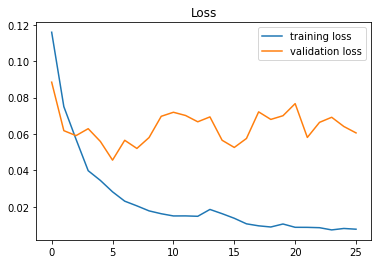

In [10]:
#set seed
ini=0
seed(ini+872527)
tf.random.set_seed(ini+87747)
    
#Define Input Shape
inp = tf.keras.Input(shape=(n_steps_in, X_train.shape[2]))

#start with a 1D-Conv Layer
cnn = tf.keras.layers.Conv1D(filters=256,
                             kernel_size=3,
                             activation='relu',
                             padding='same')(inp)
#add Pooling Layer
cnn = tf.keras.layers.MaxPool1D(padding='same')(cnn) #consolidates the feature_map information

#reshape data for next layer
cnn = tf.keras.layers.Flatten()(cnn) # flattens the data

#add a dense layer
cnn = tf.keras.layers.Dense(30, activation='relu')(cnn)

#add output neuron
output1 = tf.keras.layers.Dense(1, activation='linear')(cnn) # output neuron to get meaningful output values

#tie together
model = tf.keras.Model(inputs=inp, outputs=output1)

#define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1E-3, epsilon=1E-3, clipnorm=True)
  
#compile the model
model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])

# import matplotlib.pyplot as plt

#define early stopping callback
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20, restore_best_weights = True)

#train the model
history = model.fit(X_train, Y_train,validation_data=(X_stop, Y_stop), epochs=100, verbose=3,
                    batch_size=32, callbacks=[es])

#plot training loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss','validation loss'])
plt.title('Loss')
plt.show()

Jetzt haben wir ein fertig trainiertes Modell, das wir zur Simulation von ungesehenen Daten (TestData) verwenden können:

Wir geben dafür *X_test* in das Modell und vergleichen das Ergebnis mit *Y_test*

In [11]:
sim = model.predict(X_test)

#rescale simulated and observed values
sim = scaler_gwl.inverse_transform(sim)  # retransform to original scale
obs = scaler_gwl.inverse_transform(Y_test.reshape(-1,1))


Wir berechnen noch einige Fehlerwerte:

In [12]:
from scipy import stats

#Nash-Sutcliffe-Efficiency: NSE
NSE = 1 - ((np.sum((sim-obs) ** 2)) / (np.sum((obs - np.mean(obs)) ** 2)))

#Root Mean Squared Error
RMSE =  np.sqrt(np.mean((sim-obs) ** 2))

#Pearson r
r = stats.pearsonr(sim[:,0], obs[:,0])
r = r[0] #r

#Bias
Bias = np.mean(sim-obs)

scores = pd.DataFrame(np.array([[NSE, RMSE, r, Bias]]),
                      columns=['NSE','RMSE','r','Bias'])
scores.head()

,NSE,RMSE,r,Bias
0,0.831745,0.113306,0.915862,0.023199


Ergebnis plotten:

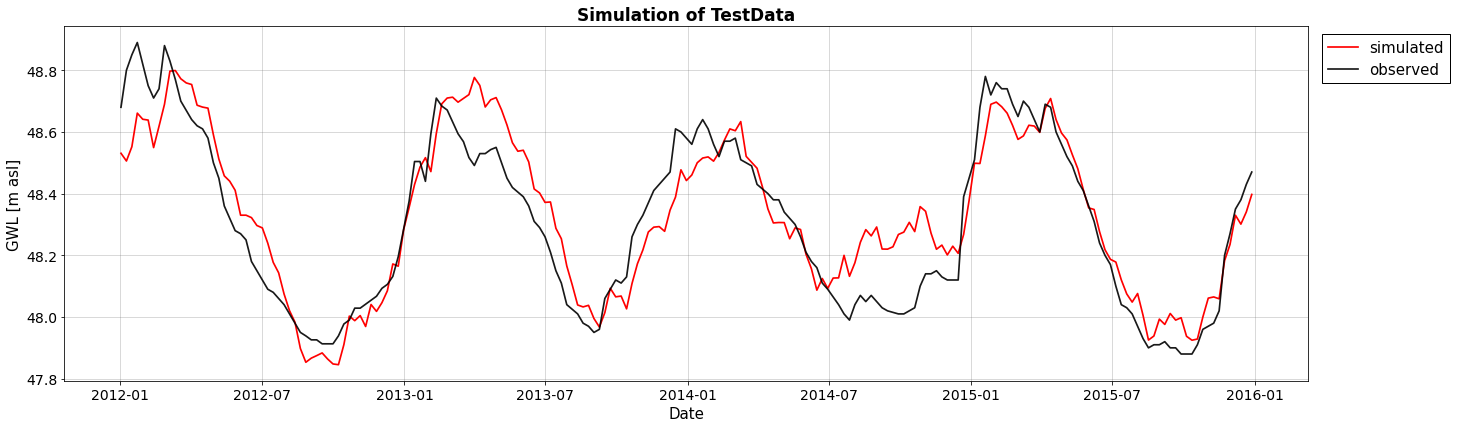

In [13]:
plt.figure(figsize=(20,6))
plt.plot(TestData.index, sim, 'r', label ="simulated", linewidth = 1.7)
plt.plot(TestData.index, obs, 'k', label ="observed", linewidth=1.7,alpha=0.9)

plt.title("Simulation of TestData", size=17,fontweight = 'bold')
plt.ylabel('GWL [m asl]', size=15)
plt.xlabel('Date',size=15)
plt.legend(fontsize=15,bbox_to_anchor=(1.12, 1),loc='upper right',fancybox = False, framealpha = 1, edgecolor = 'k')
plt.tight_layout()
plt.grid(b=True, which='major', color='#666666', alpha = 0.3, linestyle='-')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Aufgabe 1: CNN

Macht euch mit dem Modell vertraut und verändert einmal folgende Parameter:  
- Anzahl der Inputparameter
- n_steps_in
- Anzahl der Filter im 1D-Conv Layer
- Training batch size
- Epochenanzahl und Early Stopping Patience
- Welchen Zweck könnte der Inputparameter Tsin haben?

Wie ändert sich die Vorhersagegüte? Was für einenen NSE könnt ihr erreichen?

### Aufgabe 2: LSTM
Ersetzt das 1D-CNN Modell durch ein LSTM. 
Hinweis: Es sind nur Änderungen in der Zelle in der das Modell definiert wird notwendig. 

orientiert euch an folgender Struktur:

![LSTM](./LSTM.png)

hier könnt ihr die Syntax nachlesen:
https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

Einfach Googeln hilft aber auch meist weiter.

Welches des beiden Modelle erzielt eine bessere Performance? 



Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

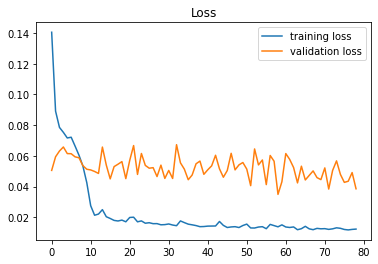

        NSE      RMSE         r      Bias
0  0.918618  0.078801  0.963095 -0.018192


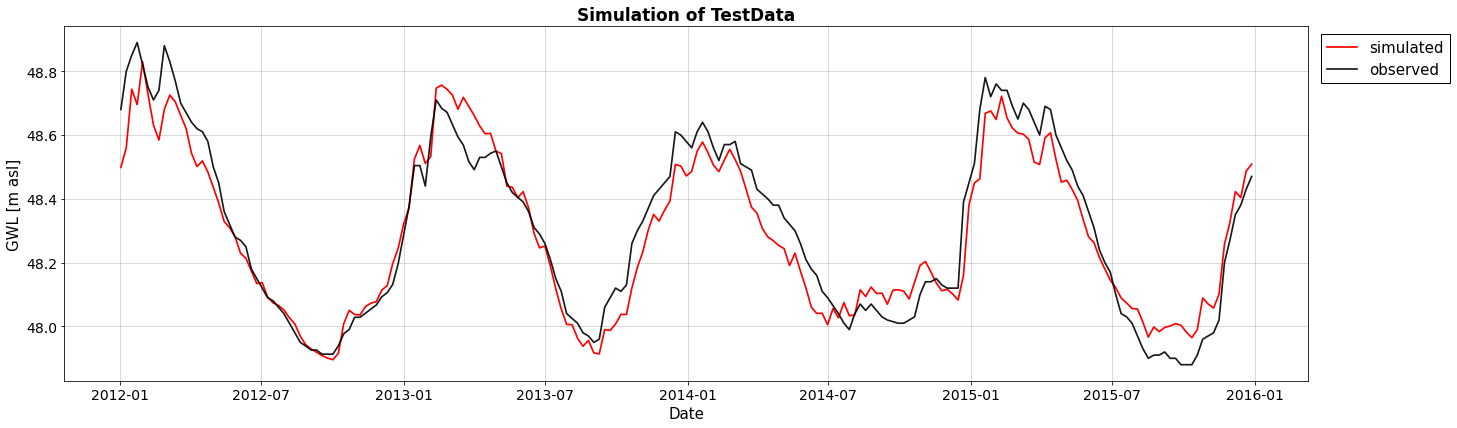

In [14]:
#set seed
ini=0
seed(ini+872527)
tf.random.set_seed(ini+87747)
    
#Define Input Shape
inp = tf.keras.Input(shape=(n_steps_in, X_train.shape[2]))

##############################################
lstm = tf.keras.layers.LSTM(64)(inp)
##############################################

#add a dense layer
lstm = tf.keras.layers.Dense(30, activation='relu')(lstm)

#add output neuron
output1 = tf.keras.layers.Dense(1, activation='linear')(lstm) # output neuron to get meaningful output values

#tie together
model = tf.keras.Model(inputs=inp, outputs=output1)

#define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1E-3, epsilon=1E-3, clipnorm=True)
  
#compile the model
model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])

# import matplotlib.pyplot as plt

#define early stopping callback
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20, restore_best_weights = True)

#train the model
history = model.fit(X_train, Y_train,validation_data=(X_stop, Y_stop), epochs=100, verbose=3,
                    batch_size=32, callbacks=[es])

#plot training loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss','validation loss'])
plt.title('Loss')
plt.show()

#simulate testset
sim = model.predict(X_test)

#rescale simulated and observed values
sim = scaler_gwl.inverse_transform(sim)  # retransform to original scale
obs = scaler_gwl.inverse_transform(Y_test.reshape(-1,1))

from scipy import stats

#Nash-Sutcliffe-Efficiency: NSE
NSE = 1 - ((np.sum((sim-obs) ** 2)) / (np.sum((obs - np.mean(obs)) ** 2)))

#Root Mean Squared Error
RMSE =  np.sqrt(np.mean((sim-obs) ** 2))

#Pearson r
r = stats.pearsonr(sim[:,0], obs[:,0])
r = r[0] #r

#Bias
Bias = np.mean(sim-obs)

scores = pd.DataFrame(np.array([[NSE, RMSE, r, Bias]]),
                      columns=['NSE','RMSE','r','Bias'])
print(scores)

#plot Test data and simulation
plt.figure(figsize=(20,6))
plt.plot(TestData.index, sim, 'r', label ="simulated", linewidth = 1.7)
plt.plot(TestData.index, obs, 'k', label ="observed", linewidth=1.7,alpha=0.9)

plt.title("Simulation of TestData", size=17,fontweight = 'bold')
plt.ylabel('GWL [m asl]', size=15)
plt.xlabel('Date',size=15)
plt.legend(fontsize=15,bbox_to_anchor=(1.12, 1),loc='upper right',fancybox = False, framealpha = 1, edgecolor = 'k')
plt.tight_layout()
plt.grid(b=True, which='major', color='#666666', alpha = 0.3, linestyle='-')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Aufgabe 3: Regularisierungstechniken - robuste Modelle

Overfitting und Robustness sind zentrale Punkte für das Training von ANNs. Neben einem klassischen Early Stopping gegen Overfitting gibt es noch weitere Ansätze.

#### Batch-Normalization Layer
Ihr kennt bereits das Vanishing Gradient Problem. BatchNorm Layer verhindern jetzt im Prinzip das Gegenteil, nämlich **Exploding Gradients**. Im Grunde wird dafür lediglich der Output des vorhergehenden Layers normalisiert.
Dies hat den Effekt, dass der Lernprozess stabilisiert und die Anzahl der Trainingsepochen, die zum Trainieren von Deep ANN benötigt werden, drastisch reduziert wird.

Mehr (ausführliche) Infos hier: https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/  oder hier: https://towardsdatascience.com/batch-normalization-the-greatest-breakthrough-in-deep-learning-77e64909d81d

#### Dropout Layer
Durch einen Dropout Layer werden im Grunde ein definierter Anteil der möglichen Pfade im Netzwerk an dieser Stelle zufällig deaktiviert (zufällig immer andere bei jedem Durchlauf). Dadurch wird das Training verrauscht und die Nodes innerhalb einer Schicht gezwungen, besser auf Inputs zu reagieren.


#### Gaußian-Noise Layer
Prinzip: Den Daten wird Rauschen hinzugefügt, sodass das Model die Zusammenhänge robuster lernen kann. Wird heute nicht in dieser Übung behandelt.  
https://keras.io/api/layers/regularization_layers/ 

### Aufgabe:

Füge zu dem Modell aus Aufgabe 1 ODER 2 einen BatchNorm Layer und einen Dropout Layer hinzu. Experimentiere mit der Dropout Rate. Welchen Effekt haben die Layer einzeln und gleichzeitig?

**Hinweis**  
Orientiere dich bei der Platzierung fürs erste an dieser Struktur:
![layer](./layer.png)



Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100


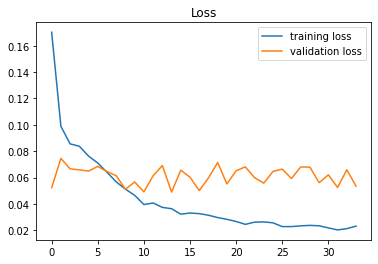

        NSE      RMSE         r      Bias
0  0.859148  0.103669  0.928184  0.010366


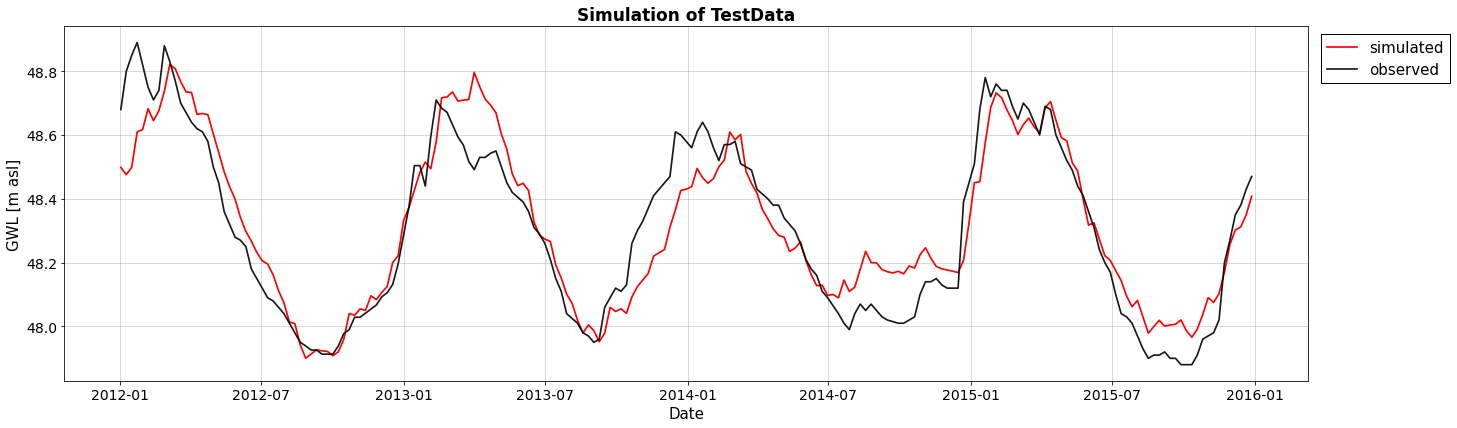

In [15]:
#set seed
ini=0
seed(ini+872527)
tf.random.set_seed(ini+87747)
    
#Define Input Shape
inp = tf.keras.Input(shape=(n_steps_in, X_train.shape[2]))

#start with a 1D-Conv Layer
cnn = tf.keras.layers.Conv1D(filters=256,
                             kernel_size=3,
                             activation='relu',
                             padding='same')(inp)
#add Pooling Layer
cnn = tf.keras.layers.MaxPool1D(padding='same')(cnn) #consolidates the feature_map information


# ###################################################
# #add Batchnorm layer
# cnn = tf.keras.layers.BatchNormalization()(cnn)
# ###################################################


###################################################
#add dropout layer 
cnn = tf.keras.layers.Dropout(0.8)(cnn)
###################################################


#reshape data for next layer
cnn = tf.keras.layers.Flatten()(cnn) # flattens the data

#add a dense layer
cnn = tf.keras.layers.Dense(30, activation='relu')(cnn)

#add output neuron
output1 = tf.keras.layers.Dense(1, activation='linear')(cnn) # output neuron to get meaningful output values

#tie together
model = tf.keras.Model(inputs=inp, outputs=output1)

#define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1E-3, epsilon=1E-3, clipnorm=True)
  
#compile the model
model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])

# import matplotlib.pyplot as plt

#define early stopping callback
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20, restore_best_weights = True)

#train the model
history = model.fit(X_train, Y_train,validation_data=(X_stop, Y_stop), epochs=100, verbose=3,
                    batch_size=32, callbacks=[es])

#plot training loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss','validation loss'])
plt.title('Loss')
plt.show()

#simulate testset
sim = model.predict(X_test)

#rescale simulated and observed values
sim = scaler_gwl.inverse_transform(sim)  # retransform to original scale
obs = scaler_gwl.inverse_transform(Y_test.reshape(-1,1))

from scipy import stats

#Nash-Sutcliffe-Efficiency: NSE
NSE = 1 - ((np.sum((sim-obs) ** 2)) / (np.sum((obs - np.mean(obs)) ** 2)))

#Root Mean Squared Error
RMSE =  np.sqrt(np.mean((sim-obs) ** 2))

#Pearson r
r = stats.pearsonr(sim[:,0], obs[:,0])
r = r[0] #r

#Bias
Bias = np.mean(sim-obs)

scores = pd.DataFrame(np.array([[NSE, RMSE, r, Bias]]),
                      columns=['NSE','RMSE','r','Bias'])
print(scores)

#plot Test data and simulation
plt.figure(figsize=(20,6))
plt.plot(TestData.index, sim, 'r', label ="simulated", linewidth = 1.7)
plt.plot(TestData.index, obs, 'k', label ="observed", linewidth=1.7,alpha=0.9)

plt.title("Simulation of TestData", size=17,fontweight = 'bold')
plt.ylabel('GWL [m asl]', size=15)
plt.xlabel('Date',size=15)
plt.legend(fontsize=15,bbox_to_anchor=(1.12, 1),loc='upper right',fancybox = False, framealpha = 1, edgecolor = 'k')
plt.tight_layout()
plt.grid(b=True, which='major', color='#666666', alpha = 0.3, linestyle='-')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Bemerkenswert: die Vorhersage mittels CNN ist selbst bei einem Dropout von 80% (!) sehr gut, sogar etwas besser als fürs CNN oben. Ein Batchnorm Layer scheint in diesem speziellen Fall eher eine Verschlechterung zu bewirken. 

Ihr könnt das natürlich auch mit einem LSTM statt einem CNN machen. 